<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/resnet_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title download
# # https://drive.google.com/file/d/1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q/view?usp=sharing
# !gdown 1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q -O gsv.zip
# !unzip /content/gsv.zip -d /content
# import shutil
# shutil.rmtree('/content/google_street_view/meta_data', ignore_errors=True) # delete the meta_data folder

# # clip cleaned
# # https://drive.google.com/file/d/1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB/view?usp=share_link
# !gdown 1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB -O gsv.zip
# !unzip /content/gsv.zip -d /

# gsv 70k
# https://drive.google.com/file/d/1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8/view?usp=share_link
!gdown 1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8 -O gsv.zip
!unzip /content/gsv.zip -d /

# # !ls
!ls -a /content/gsv70k
!rm -R /content/gsv70k/.ipynb_checkpoints
# # !rm -R /content/gsv/06/.ipynb_checkpoints

# # https://bestasoff.medium.com/how-to-fine-tune-very-large-model-if-it-doesnt-fit-on-your-gpu-3561e50859af
!pip install bitsandbytes


In [28]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py

from PIL import ImageOps, ImageFilter
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class GaussianBlur(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 1.9 + 0.1
            # return img.filter(ImageFilter.GaussianBlur(sigma))
            return transforms.GaussianBlur(kernel_size=5, sigma=sigma)(img)
        else:
            return img

class Solarization(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

class Cutout(object):
    def __init__(self, p=0.5, mask_size=140, mask_color=(0, 0, 0)):
        self.p = p
        self.mask_size = mask_size
        self.mask_color = mask_color
        self.mask_size_half = self.mask_size // 2
        # offset = 1 if mask_size % 2 == 0 else 0
    def __call__(self, img):
        if np.random.rand() > self.p:
            return img
        else:
            img = np.asarray(img).copy()
            h, w = img.shape[:2] # 480x600
            cx = np.random.randint(0, w)
            cy = np.random.randint(0, h)
            xmin, xmax = cx - self.mask_size_half, cx + self.mask_size_half
            ymin, ymax = cy - self.mask_size_half, cy + self.mask_size_half
            xmin, xmax = max(0, xmin), min(w, xmax)
            ymin, ymax = max(0, ymin), min(h, ymax)
            img[ymin:ymax, xmin:xmax] = self.mask_color
            return img


class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                # transforms.RandomResizedCrop(224, interpolation=InterpolationMode.BICUBIC),#224
                # transforms.RandomResizedCrop((400,640), interpolation=InterpolationMode.BICUBIC),#224
                # transforms.RandomResizedCrop((400,640), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomResizedCrop((400,640), scale=(0.7, 1.0), ratio=(0.8, 1.25), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5), # 0.5
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,), # brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8
                transforms.RandomGrayscale(p=0.2), # 0.2
                GaussianBlur(p=1.0), # 1.0
                # Solarization(p=0.0), # 0.0
                Cutout(p=1.0),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225
            ])

    def __call__(self, sample):
        x1 = self.transform(sample)
        # x2 = transforms.ToTensor()(sample)
        return x1
# https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py



# https://github.com/hysts/pytorch_cutout/blob/master/dataloader.py
# https://arxiv.org/pdf/1708.04552.pdf
# size of the cutout region is a more important hyperparameter than the shape
# randomly select a pixel coordinate within the image as a center point and then place the cutout mask around that location.
# alternative randomly apply cutout constrained within the image region, but with 50% probability so that the network sometimes receives unmodified images
def cutout(p=0.5, mask_size=16, mask_color=(0, 0, 0)):
    mask_size_half = mask_size // 2
    # offset = 1 if mask_size % 2 == 0 else 0
    def _cutout(image):
        image = np.asarray(image).copy()
        if np.random.random() > p:
            return image
        h, w = image.shape[:2]
        cx = np.random.randint(0, w)
        cy = np.random.randint(0, h)
        xmin, xmax = cx - mask_size_half, cx + mask_size_half
        ymin, ymax = cy - mask_size_half, cy + mask_size_half
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)
        image[ymin:ymax, xmin:xmax] = mask_color
        return image
    return _cutout



In [ ]:
# @title data weighted
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# transform = transforms.Compose(transforms.ToTensor())

# dir='/content/google_street_view'
dir='/content/gsv70k'

# data = datasets.ImageFolder(dir, transform=transform)
data = datasets.ImageFolder(dir, transform=None)
torch.manual_seed(0)

# train_data, test_data = torch.utils.data.random_split(data, [.85,.15])
# https://www.scaler.com/topics/pytorch/how-to-split-a-torch-dataset/
data_size = len(data)
indices = np.arange(data_size)
np.random.shuffle(indices)
split_index = int(np.floor(0.9 * data_size))
train_idx, test_idx = indices[:split_index], indices[split_index:]
train_data = torch.utils.data.Subset(data, train_idx)
test_data = torch.utils.data.Subset(data, test_idx)
targets = np.array(data.targets)
train_targets = targets[train_idx]
test_targets = targets[test_idx]


from torch.utils.data import Dataset
class DatasetWrap(Dataset):
    def __init__(self, dataset, transform=None):
        super(DatasetWrap, self).__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
# train_data = DatasetWrap(train_data, transform)
test_data = DatasetWrap(test_data, transform)

batch_size = 16 # 64
num_batches=int(np.ceil(len(train_data)/batch_size))

# https://stackoverflow.com/questions/62319228/number-of-instances-per-class-in-pytorch-dataset
from collections import Counter
class_count = torch.tensor(list(Counter(data.targets).values()))
weights=1./class_count
# weights=sum(class_count)/class_count
# print(weights)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler

train_weight = weights[train_targets]
test_weight = weights[test_targets]
train_sampler = torch.utils.data.WeightedRandomSampler(train_weight, len(train_weight))
test_sampler = torch.utils.data.WeightedRandomSampler(test_weight, len(test_weight))
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
data, train_data, test_data = None, None, None


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# dataiter=None
# print(labels)

# dataiter = iter(test_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# dataiter=None


In [22]:
c=0
print(len(test_loader))
# for batch, (x, y) in enumerate(train_loader):
for batch, (x, y) in enumerate(test_loader):
    print(torch.bincount(y)) # torch count number of elements with value in tensor
    c+=1
    if c>5: break


3495
tensor([2, 4, 2, 2, 2, 4])
tensor([3, 1, 3, 4, 2, 3])
tensor([2, 1, 6, 3, 3, 1])
tensor([2, 3, 4, 3, 2, 2])
tensor([3, 3, 2, 4, 1, 3])
tensor([2, 4, 2, 3, 2, 3])


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
# imshow(torchvision.utils.make_grid(images))
dataiter=None

dataiter = iter(test_loader)
images, labels = next(dataiter)
print(images.shape)
# imshow(torchvision.utils.make_grid(images))
dataiter=None

In [ ]:
%matplotlib inline 
# images, labels = next(dataiter)

# from matplotlib import pyplot as plt
image=images[0]
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
# # https://pytorch.org/vision/0.12/models.html#id10
model = models.resnet152(pretrained=True) # 18 34 50 101 152

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 6, bias=False),
    nn.Softmax(dim=1),
    )
# # model.mods = [module for k, module in model._modules.items()]
# # modules = [module for k, module in model._modules.items()]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
model = torch.compile(model.to(device),mode='max-autotune')


In [ ]:
# @title vit
# https://arxiv.org/pdf/2010.11929.pdf
import torch
import torch.nn as nn
from torchvision import models
# https://pytorch.org/vision/main/models/vision_transformer.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16
# model = models.vit_l_16(weights='DEFAULT') # small vit_b_16 vit_b_32 vit_l_16 vit_l_32 vit_h_14 big
# # VisionTransformer(image_size, patch_size, num_layers, num_heads, hidden_dim, mlp_dim)
# num_ftrs = model.heads.head.in_features
# # num_ftrs = model.heads[-1].in_features
# model.heads = nn.Sequential(
#     # nn.Dropout(0.2),
#     nn.Linear(num_ftrs, 6, bias=False),
#     nn.Softmax(dim=1),
#     )


!pip install timm
# https://github.com/huggingface/pytorch-image-models/issues/908
import timm
# model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = timm.create_model('vit_base_patch16_224', img_size=(400, 640), pretrained=True)
# [print(x) for x in timm.list_models('vit*',pretrained=True)]
# https://huggingface.co/google/vit-base-patch16-224
# https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
# vit_base_patch16_224 compile,no ckpt # patch_size=16, embed_dim=768, depth=12, num_heads=12
# vit_base_patch16_384
# vit_large_patch16_224 explodesgpu # patch_size=16, embed_dim=1024, depth=24, num_heads=16
# vit_large_patch16_384 # patch_size=16, embed_dim=1024, depth=24, num_heads=16

# or fine tune huge
# vit_large_patch14_224 # patch_size=16, embed_dim=1024, depth=24, num_heads=16
# vit_large_patch16_384


num_ftrs = model.head.in_features
model.head = nn.Sequential(
    # nn.Dropout(0.2),
    nn.Linear(num_ftrs, 6, bias=False),
    nn.Softmax(dim=1),
    )
# model.set_grad_checkpointing()

# print(model.patch_embed.grid_size) # (25, 40)
# print(model.pos_embed.shape) # [1, 1001, 768]
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

# print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
model = torch.compile(model.to(device),mode='max-autotune')



In [ ]:
# @title inception
import torch
import torch.nn as nn
from torchvision import models
# # https://pytorch.org/vision/0.12/models.html#id10
model = models.inception_v3(pretrained=True)
# https://discuss.pytorch.org/t/inception-v3-is-not-working-very-well/38296/16

# https://colab.research.google.com/github/CaoCharles/Deep-Learning-with-PyTorch/blob/master/2_Inception.ipynb
model.aux_logits = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 6, bias=False),
    nn.Softmax(dim=1),
    )
# # model.mods = [module for k, module in model._modules.items()]
# # modules = [module for k, module in model._modules.items()]
# pytorch "inception" v3 "gradient checkpointing" https://github.com/jianweif/OptimalGradCheckpointing


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
model = torch.compile(model.to(device),mode='max-autotune')



In [ ]:
# @title try

# # check model's input and output dimensions are correct
# X = torch.rand(64, 3, 32, 32, device=device)
X = torch.rand(16, 3, 400, 640, device=device)
# X = torch.rand(16, 3, 224, 224, device=device)
model.eval()

# 224x224
# 16x16 / 32x32 patch
# -> 14x14=196 7x7=49 seq length
# 400x640 -> 25x40=1000 seq length


logits = model(X)

# modules = [module for k, module in model._modules.items()]
# for i,x in enumerate(modules):
#     print(i,x)

# logits = checkpoint_sequential(functions=modules, segments=1, input=X)

print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))

pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(y_pred)



In [31]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()
# https://github.com/prigoyal/pytorch_memonger/blob/master/models/optimized/resnet_new.py
from torch.utils.checkpoint import checkpoint, checkpoint_sequential


# train function with automatic mixed precision
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(): # automatic mixed percision
            # pred = model(sx) # default

            # pred = model(sx)[0] # inception

            modules = [module for k, module in model._modules.items()]
            pred = checkpoint_sequential(functions=modules, segments=1, input=sx) # gradient checkpointing for resnet and inception only
            # # pred = checkpoint_sequential(functions=model.mods, segments=1, input=sx)

            loss = loss_fn(pred, sy) # /4 to scale by gradient accumulation_steps
        
        scaler.scale(loss).backward()
        if ((batch + 1) % 4 == 0) or (batch + 1 == len(dataloader)): # gradient accumulation
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        loss_list.append(loss.item())
        # loss.backward()
        # optimizer.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # if verbose: print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss


In [5]:
pth='/content/lr.pth'
torch.save(model.state_dict(), pth) # save temporary model for lr finding


In [ ]:
# @title LR range test
# 1cycle super convergencehttps://arxiv.org/pdf/1708.07120.pdf
# # cyclic lr https://arxiv.org/pdf/1506.01186.pdf
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall

# one training run of the network for a few epochs

epochs=1
min_lr= 1e-7
max_lr= 1e-4 # 1e-2
# 152: 1e-7 - 1e-4      result 3e-7 - 3e-6

loss_fn = nn.CrossEntropyLoss()
model.load_state_dict(torch.load("lr.pth"))
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)
import bitsandbytes as bnb
optimizer = bnb.optim.AdamW(model.parameters(), lr=min_lr, betas=(0.9, 0.999), optim_bits=8)

total_steps=int(np.ceil(num_batches/4)*epochs)

# min_lr* gamma^total_steps = max_lr
gamma = np.exp(np.log(max_lr/min_lr)/total_steps) # for scheduler step every optimizer step
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)
train_lst, test_lst=[],[]
lr_list=np.ones(total_steps)*min_lr*gamma**np.arange(total_steps)


for i in range(epochs):
    train_ls = strain(test_loader, model, loss_fn, optimizer, scheduler)    
    train_lst.extend(train_ls)


gamma = np.exp(np.log(max_lr/min_lr)/(total_steps*4)) # total_steps*4 bec grad accumulation, loss step 4x per lr step
lr_list=np.ones(total_steps*4)*min_lr*gamma**np.arange(total_steps*4)

# https://stackoverflow.com/a/53472966/13359815
from scipy.ndimage.filters import gaussian_filter1d
train_lstsm = gaussian_filter1d(train_lst, sigma=30)

import matplotlib.pyplot as plt
plt.plot(lr_list, train_lst)
plt.plot(lr_list, train_lstsm)
plt.xscale('log')
# plt.plot(train_lst)
# plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.close()


In [ ]:
# @title wwwwwwwww
import time
start = time.time()
acc_lst, train_lst, test_lst=[],[],[]
loss_fn = nn.CrossEntropyLoss()


base_lr, max_lr = 3e-7, 3e-6 # 1e-5, 1e-3 #0.5#
# base_lr, max_lr = 3e-6, 3e-4
end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1

# print(num_batches)
epochs = 5 #5 20
# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-3/1e-1)/epochs) # for scheduler step every epoch
# gamma = np.exp(np.log(end_lr/start_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# print(gamma)
# optimizer = torch.optim.SGD(model.parameters(), lr = start_lr, momentum=0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
import bitsandbytes as bnb # 8bit optimizer
optimizer = bnb.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), optim_bits=8)
# optimizer = bnb.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.9, 0.999), optim_bits=8)
# 152 1e-5
# cnn 3e-4

div_factor = max_lr/base_lr
total_steps=int(np.ceil(num_batches/4)*epochs +1) # +1 to excluse uptick at the end of onecycle
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)



for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    print(lr)
    train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    # train_ls = strain(train_loader, model, loss_fn, optimizer)
    correct, test_loss = test(test_loader, model, loss_fn)
    # scheduler.step()
    train_lst.extend(train_ls)
    test_lst.append(test_loss)
    acc_lst.append(correct)
print("Done!")

end = time.time()
print("time: ",end - start)

print(len(train_lst), len(test_lst))
import matplotlib.pyplot as plt
plt.plot(train_lst)
plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.plot(acc_lst)
plt.show()
plt.close()


torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))

# resnet 18, 60/61 38.4%, 528s
# resnet 18, 58/61 39.8%, 523s
# resnet 18 compile , 58/61 40.4%, 555s
# resnet 18 compile augment , 58/61 36.4%, 1941 # augment on cpu, takes longer
# resnet 18 augment lr3e-4:3e-3, 58/61 37.7%, 1863s
# resnet 18 augment 10epoch lr1e-5:3e-4, 58/61 33.5%, 3387s
# resnet 18 compile lr1e-5:3e-4, 58/61 35.0%, 493s
# resnet 18 compile scratch lr1e-5:1e-3, 58/61 26.8%, 475s
# resnet 18 compile lr1e-5:1e-3, 55/61 47.3%, 480s
# resnet 18 compile lr1e-5:1e-3, 52/61 51.7% 503s
# resnet 18 compile lr1e-5:1e-3, unfreeze 51.0%, 550s
# resnet 18 compile lr1e-5:1e-4, unfreeze 52.7%, 518s
# resnet 34 compile lr1e-5:1e-4, unfreeze bitsadamW batch16*4
# resnet 152 compileoverhead lr3e-7:3e-6, bitsadamW batch16*4 ckpt 53.8%, 2066s
# resnet 152 from53.8% augment+cutout lr3e-7:3e-6, 53.8%, 2088s
# resnet 152 comile augment+cutout lr1e-5 /4 1epoch 48.3%, 454s
# resnet 152 comile augment+cutout lr1e-5 1epoch 48.4%, 446s
# resnet 152 comilemaxautotue augment+cutout lr1e-5 1epoch 47.7%, 448
# resnet 152 clipclean comilemax augment+cutout lr1e-5 10epoch 45.1%, 1585 *2
# resnet 152 clipclean comilemax augmax lr1e-6:3e-5 20epoch 
# resnet 152 clipclean compilemax lr3e-7:1e-5,  
# resnet 152 70k augment compilemax lr3e-7:3e-6 5epoch, 


# vit b16 lr1e-5 5epochs 41.3%, 466s # 4.4ram, 5.5vram
# vit l16 lr1e-5 5epochs # 32.0%, 1242s 4.5ram, 8.0vram
# vit l16 lr3e-7;1e-5 5epochs # 45.4%, 1315s 4.5ram, 8.0vram
# vit l32 lr1e-5 5epochs # .ram, .vram
# vit_large_patch16_384
# vit_base_patch16_224 maxcompile nockpt lr3e-7;1e-5 5epochs # 45.2%, 2272s 5.3ram, 11.0vram

# inception




Epoch 1
-------------------------------
3.000000000000001e-07
loss: 1.796893  [    0/62905]
loss: 1.790961  [ 6288/62905]
loss: 1.771271  [12576/62905]
loss: 1.778975  [18864/62905]
loss: 1.741662  [25152/62905]
loss: 1.628576  [31440/62905]


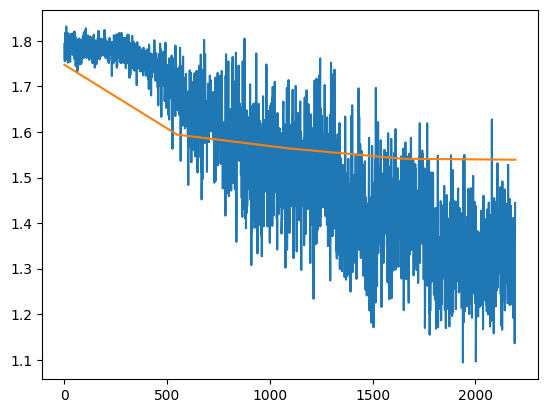

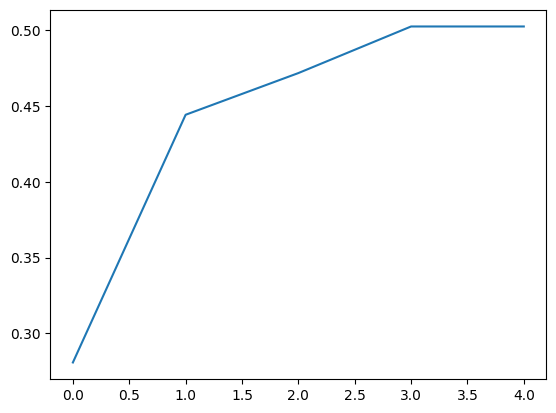

In [ ]:
# correct, test_loss = test(test_loader, model, loss_fn)


plt.plot(train_lst)
plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.plot(acc_lst)
plt.show()
plt.close()

10
dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'initial_lr', 'max_lr', 'min_lr', 'max_momentum', 'base_momentum'])
{'lr': 3e-07, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.01}
0 lr:  3.423692637641714e-07
1 lr:  4.68736785154859e-07
2 lr:  6.768946883596837e-07
3 lr:  9.632060673557662e-07
4 lr:  1.3226685294274905e-06
5 lr:  1.7490015962784307e-06
6 lr:  2.2347564356773297e-06
7 lr:  2.7714460064220355e-06
8 lr:  3.34969334274663e-06
9 lr:  3.9593953873671245e-06
10 lr:  4.589899510697507e-06
11 lr:  5.23018963211684e-06
12 lr:  5.869078691402435e-06
13 lr:  6.495404107494945e-06
14 lr:  7.0982228095669015e-06
15 lr:  7.667002432838893e-06
16 lr:  8.191805338596656e-06
17 lr:  8.663462243236782e-06
18 lr:  9.073732422718496e-06
19 lr:  9.415447693351472e-06
20 lr:  9.682637653307385e-06
21 lr:  9.870633996652829e-06
22 lr:  9.976152077343307e-06
23 lr:  9.997348298103493e-06
24 lr:  9.933852321503204e-06
25 lr:  9.786773540441636e-06
26 lr:  9.55868169498844

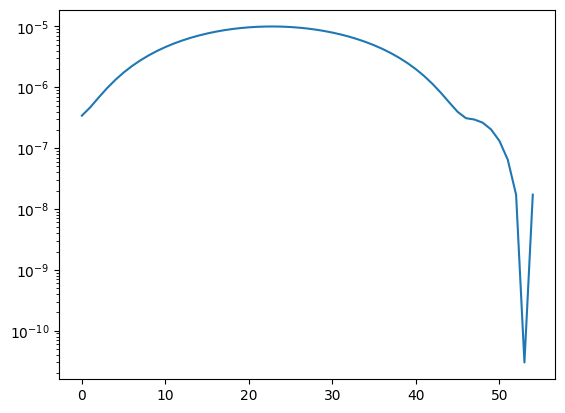

In [ ]:

# num_batches=int(np.ceil(len(train_dataset)/batch_size))
num_batches=10
print(num_batches)
epochs = 10 #5 20
# num_iter= epochs*num_batches #20
num_iter= 220



base_lr, max_lr = 3e-7, 1e-5 # 1e-5, 1e-3 #0.5#
# base_lr, max_lr = 3e-6, 3e-4
end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1


# optimizer = torch.optim.SGD(model.parameters(), lr = start_lr, momentum=0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
import bitsandbytes as bnb # 8bit optimizer
optimizer = bnb.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), optim_bits=8)

div_factor = max_lr/base_lr

# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)


print(optimizer.param_groups[0].keys())
print(optimizer.defaults)
# https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR



# epochs=epochs, steps_per_epoch=num_batches
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)

lr_list=[]
mm_list=[]
mm1_list,mm2_list=[],[]
# for x in range(total_steps):
for x in range(num_iter):
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    print(x, "lr: ",lr)
    lr_list.append(lr)

print(mm_list)

import matplotlib.pyplot as plt
plt.plot(lr_list)
plt.yscale('log')
plt.show()


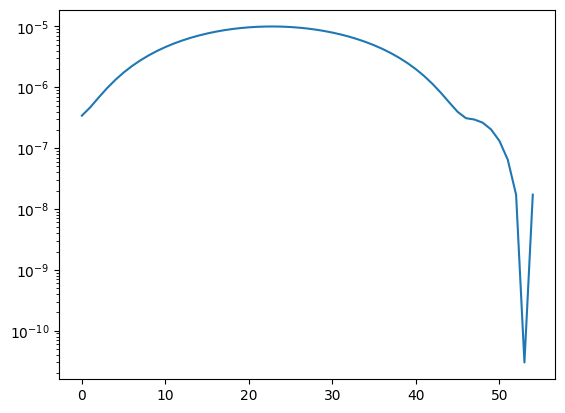

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lr_list)
plt.yscale('log')
plt.show()

In [ ]:
# @title save

from google.colab import drive
drive.mount('/content/drive')

# pth='/content/drive/MyDrive/frame/vit.pth'
# pth='/content/drive/MyDrive/frame/res1e-5.pth'
# pth='/content/drive/MyDrive/frame/res2e-5.pth'

# torch.save(model.state_dict(), pth)
# model.load_state_dict(torch.load(pth))
# model.load_state_dict(torch.load("model.pth"))

# # matt152 # https://drive.google.com/file/d/1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J/view?usp=sharing
# !gdown 1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J -O res152.pth
# model.load_state_dict(torch.load("res152.pth"))



Mounted at /content/drive


In [ ]:
# dir='/content/google_street_view'

# # data = datasets.ImageFolder(dir, transform=transform)
# data = datasets.ImageFolder(dir, transform=None)
# torch.manual_seed(0)
# train_data, test_data = torch.utils.data.random_split(data, [.85,.15])

# # train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
# train_data = DatasetWrap(train_data, transform)
# test_data = DatasetWrap(test_data, transform)


# batch_size = 16 # 64
# num_batches=int(np.ceil(len(train_data)/batch_size))

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
# # data, train_data, test_data = None, None, None


# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images))
# dataiter=None


%matplotlib inline 
from matplotlib import pyplot as plt

# dataiter = iter(train_data)


# img,label = next(iter(sample_ds))
i=5
# print(len(test_data))
# img,label=test_data[i]
img,label=sample_ds[i]
print(img.shape)
# print(type(img))
model.eval()
pred=model(img.unsqueeze(0).to(device))
pred_probab = nn.Softmax(dim=1)(pred)
y_pred = pred_probab.argmax(1)
print(pred_probab)
print("pred: ",y_pred.item())
# print(img)
# image=images[0]

print("actual: ",label)
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()


In [ ]:

model.eval()
count=0
i=138
rong_lst=[]

while count<20:
    img,label=test_data[i]
    pred=model(img.unsqueeze(0).to(device))
    pred_probab = nn.Softmax(dim=1)(pred)
    y_pred = pred_probab.argmax(1)
    if y_pred.item() != label:
        print("pred: ",y_pred.item(),", actual: ",label)
        # plt.imshow(np.transpose(img, (1, 2, 0)))
        # plt.show()
        imshow(img)
        rong_lst.append(img)
        count+=1
    i+=1


# 20/137 wrong


In [ ]:
print(i)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# print(torch.stack(rong_lst).shape)
# print(len(rong_lst))
# print(rong_lst[0].shape)
imshow(torchvision.utils.make_grid(torch.stack(rong_lst),nrow=4))
